In [1]:
#!pip install EnsemblePursuit
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler

In [4]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39_total/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


(18795, 50)
None
(642,)


(array([ 26., 176., 218., 141.,  64.,  15.,   0.,   1.,   0.,   1.]),
 array([ 1.1378856 ,  3.49444619,  5.85100679,  8.20756738, 10.56412798,
        12.92068857, 15.27724917, 17.63380976, 19.99037036, 22.34693095,
        24.70349155]),
 <a list of 10 Patch objects>)

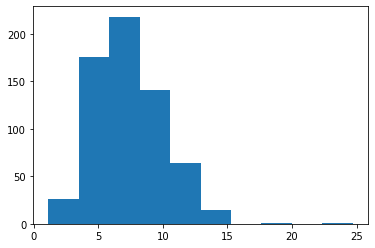

In [6]:
#Select stim ensemble, make weights for stim ens
U=np.load('U.npy')
print(print(U.shape))
stim_ens_inds=np.nonzero(U[:,13])[0]
print(stim_ens_inds.shape)
stim_k=7.5
stim_theta=1.0
stim_weights=np.random.gamma(shape=stim_k,scale=stim_theta,size=(stim_ens_inds.shape[0],))
plt.hist(stim_weights)

(463,)


(array([228., 114.,  63.,  31.,  13.,   8.,   2.,   0.,   3.,   1.]),
 array([2.87081784e-03, 1.33743264e+00, 2.67199446e+00, 4.00655628e+00,
        5.34111810e+00, 6.67567992e+00, 8.01024174e+00, 9.34480356e+00,
        1.06793654e+01, 1.20139272e+01, 1.33484890e+01]),
 <a list of 10 Patch objects>)

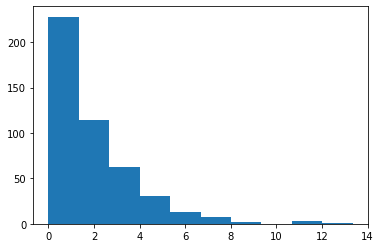

In [7]:
#Select beh ensemble, make weights for stim_ens
beh_ens_inds=np.nonzero(U[:,8])[0]
print(beh_ens_inds.shape)
beh_k=1.0
beh_theta=2.0
beh_weights=np.random.gamma(shape=beh_k,scale=beh_theta,size=(beh_ens_inds.shape[0],))
plt.hist(beh_weights)

In [8]:
weights=np.hstack((stim_weights,beh_weights))
print(weights.shape)

(1105,)


In [9]:
stim_inp=S[stim_ens_inds]
beh_imp=S[beh_ens_inds]
input_patterns=np.vstack((stim_inp,beh_imp))

In [10]:
del spks

In [11]:
del S

In [12]:
print(input_patterns.shape)

(1105, 30560)


In [311]:
N_E=1

r_0 = 1.0
r_max = 20.0 #maybe should set to more realistic value (e.g. =20)?

dt = .001

alpha = 0.01
BCM_lambda = 0.9

theta_BCM = 1.0

theta_BCM = np.ones(1105)*1.0

BCM_target = 2.0
theta_BCM_dt = .001

W_max = 1.0

def update_theta_BCM(x,theta_BCM):
    x_arr = x.reshape(x.size,)
    theta_BCM += theta_BCM_dt*((x_arr[:N_E]/BCM_target)*x_arr[:N_E] - theta_BCM)

    return theta_BCM

def update_weights(_x,_W,_theta_BCM,input_patterns):

    _W[:N_E] += alpha*_x*np.dot(input_patterns,(input_patterns-_theta_BCM))

    # bounding weights to be positive
    _W[:N_E] = _W[:N_E]*(0.5 * (np.sign(_W[:N_E]) + 1))

    # bounding weights below max value
    _W[_W>W_max] = W_max
    # no self-connections
    #np.fill_diagonal(_W,0.0)
    return W

def update_state_sliding_threshold(x,W,H,theta_BCM,input_patterns):
    H=0
    x += dt*(-1*x + np.dot(W,input_patterns) + H)

    # only allow positive firing rates
    Ex = x*(0.5 * (np.sign(x) + 1))

    #W = update_weights(x,W,theta_BCM,input_patterns)

    theta_BCM = update_theta_BCM(input_patterns,theta_BCM)

    return theta_BCM

def update_rates(x):
    #rates = x
    x[x<=0] = r_0*np.tanh(x[x<=0]/r_0)
    x[x>0] = (r_max-r_0)*np.tanh(x[x>0]/(r_max-r_0))

    return x

def update_state(x,W,input_patterns,theta_BCM):
    H=0
    x += dt*(-1*x + np.dot(W,update_rates((input_patterns))))
    #x += dt*(-1*x +W*update_rates(x) + H)
    # only allow positive firing rates
    x = x*(0.5 * (np.sign(x) + 1))

    W = update_weights(x,W,theta_BCM,input_patterns)

    theta_BCM=update_state_sliding_threshold(x,W,H,theta_BCM,input_patterns)
    
    return x,W,theta_BCM

In [312]:
def run_net_plastic(x,W,input_patterns,T=1000,N_sample=N_E):
    pop_rate = []
    theta_BCM=0.5
    #ext_OU = prep_net_run(T)
    T=10000
    
    Ws=[]
    
    xs=[]
    for i in range(T):
        H=0
        #H_noisy = H+ext_OU[i]+OU_drive[i]
        H_noisy=0
        x,W, theta_BCM = update_state(x,W,input_patterns[:,i],theta_BCM)

        Ws.append(W)
        xs.append(x)
    return xs, Ws

In [303]:
x=np.zeros((1,))
W=weights*0.0001

xs,Ws=run_net_plastic(x,W,input_patterns)
#print(xs)

[[0.03060378]
 [0.73404204]
 [1.3647854 ]
 ...
 [2.14680878]
 [1.94016035]
 [1.75926602]]


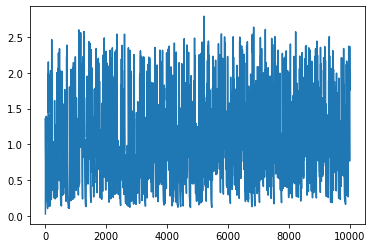

In [313]:
plt.plot(xs)
xs=np.array(xs)
print(xs)

In [314]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
ly, lx, nstim = mov.shape
#print(nstim)
NT = 10000
NN=1
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
#ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ xs[itrain])) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, 1))
B0 = gaussian_filter(B0, [.75, .75, 0])

10000


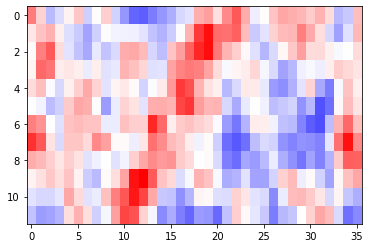

In [315]:
rf = B0[:,:,0]
rfmax = np.max(B0)
# rfmax = np.max(np.abs(rf))
plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax)

In [209]:
print(xs.shape)

AttributeError: 'list' object has no attribute 'shape'

In [226]:
U,S,V=np.linalg.svd(np.array(Ws).T)

In [227]:
print(U.shape)

(1105, 1105)


In [181]:
print(Ws[100])

[-0.          1.          1.         ...  1.          0.10619288
  1.        ]


In [281]:
Ws=np.array(Ws)

In [245]:
import seaborn as sns

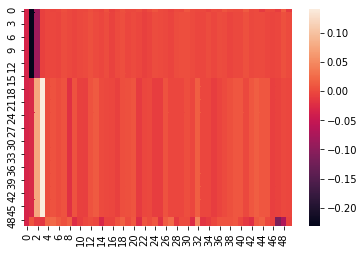

In [246]:
sns.heatmap(U[:50,:50])

In [247]:
print(S)

[3.11512890e+03 3.46066200e-11 2.05481003e-11 ... 3.11263905e-13
 2.06745011e-13 5.73279641e-14]


In [248]:
from sklearn.decomposition import PCA

In [276]:
pcs=PCA(n_components=10)
pz=pcs.fit_transform(np.array(Ws).T)

In [277]:
pcs.explained_variance_ratio_

array([1.00000000e+00, 1.40917283e-17, 1.00868913e-35, 5.43867853e-37,
       1.33056625e-37, 1.25784161e-47, 8.61893025e-49, 3.69870812e-49,
       2.83582626e-49, 2.53457228e-49])

(10000, 1105)


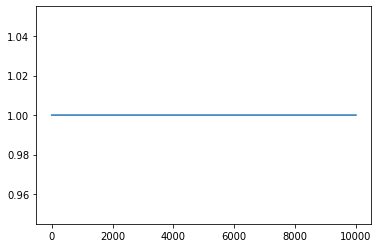

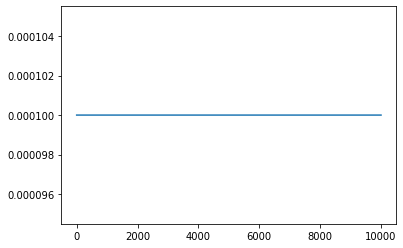

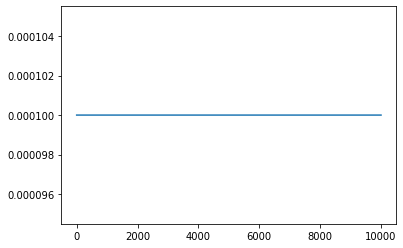

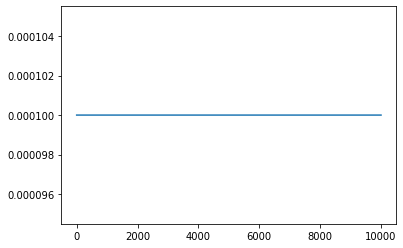

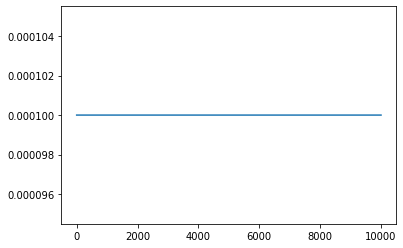

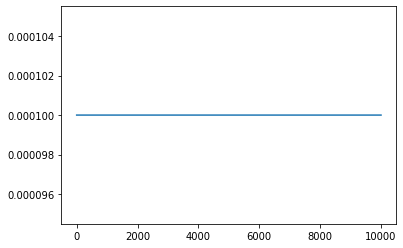

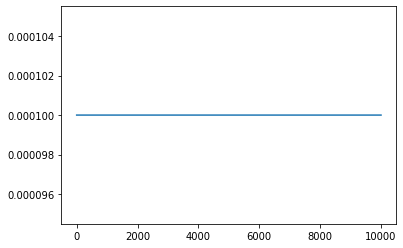

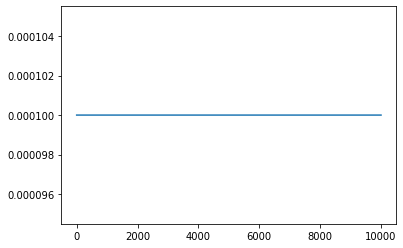

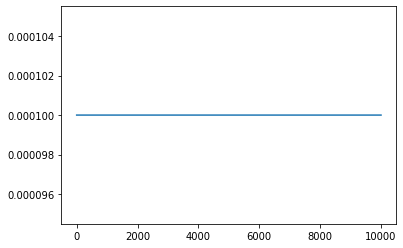

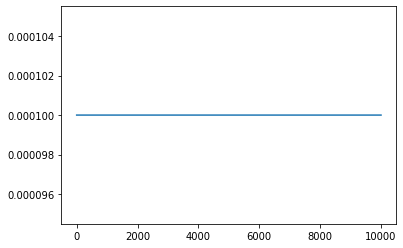

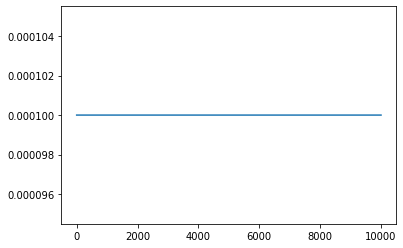

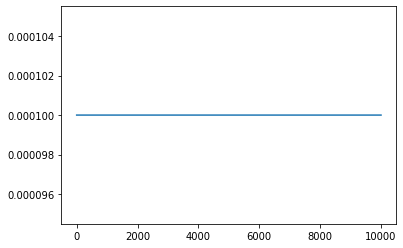

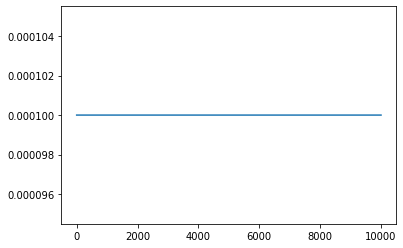

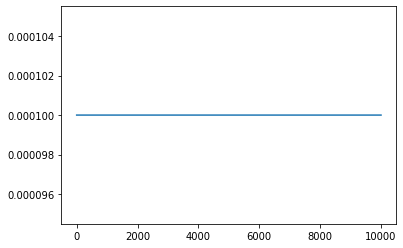

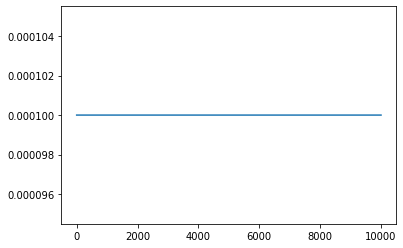

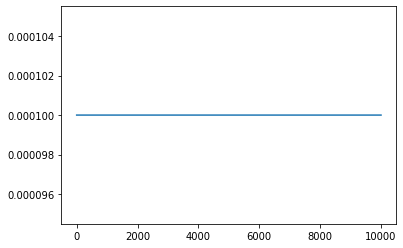

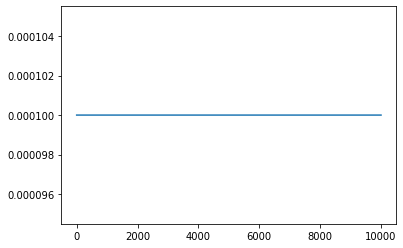

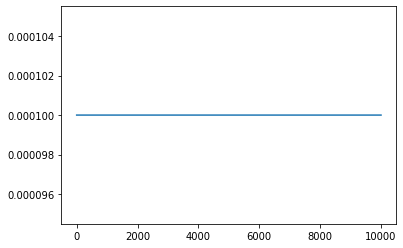

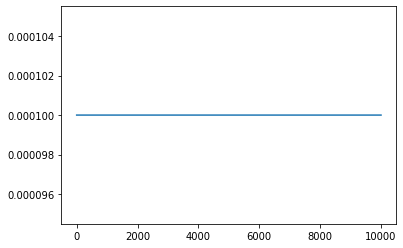

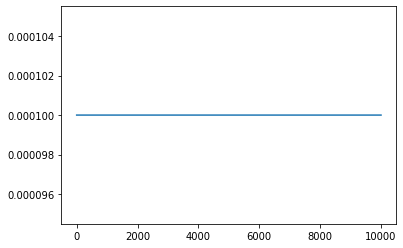

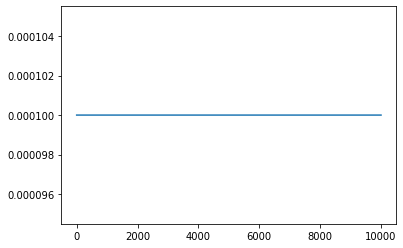

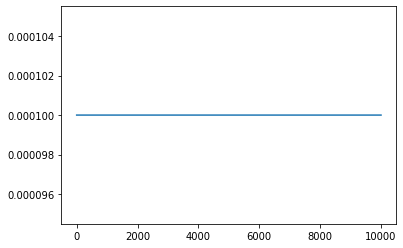

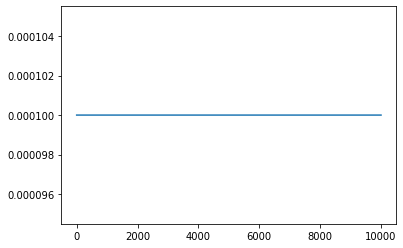

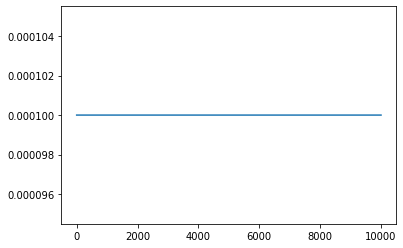

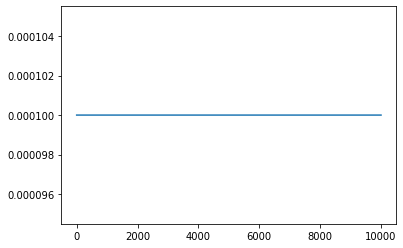

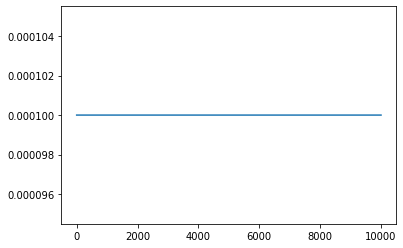

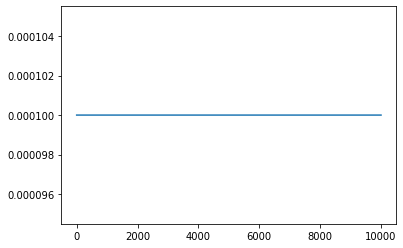

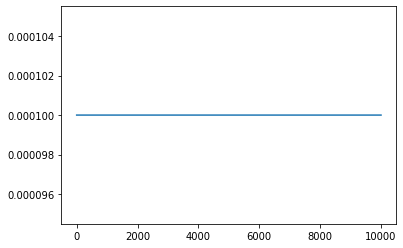

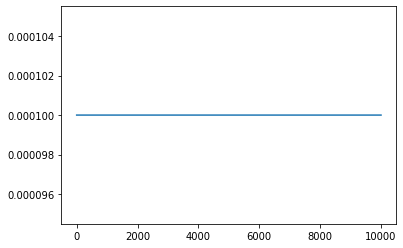

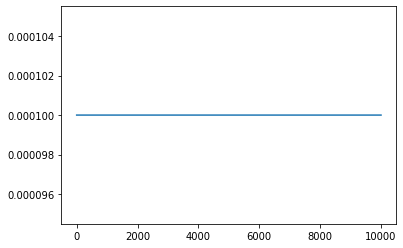

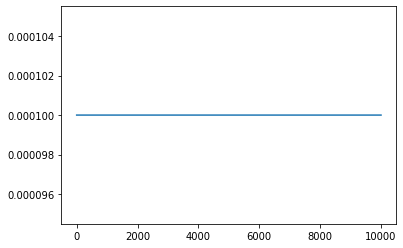

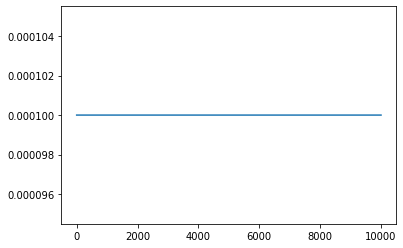

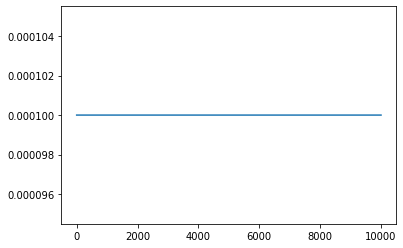

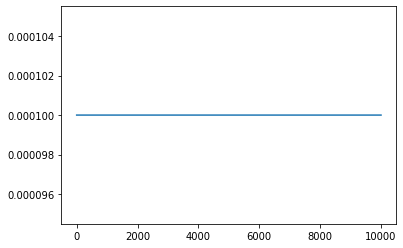

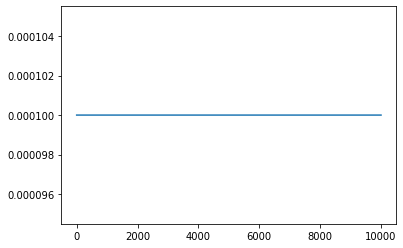

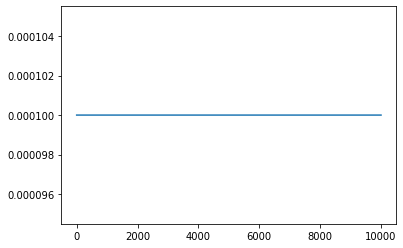

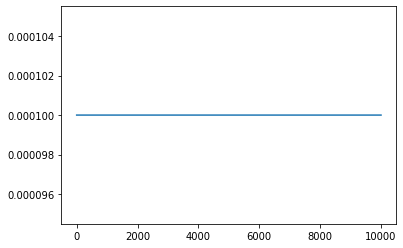

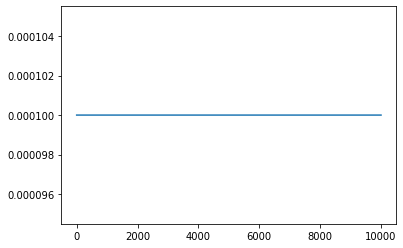

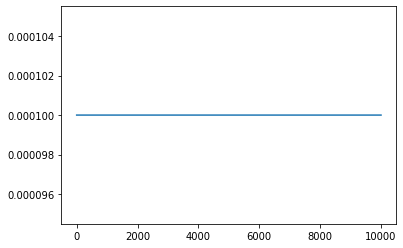

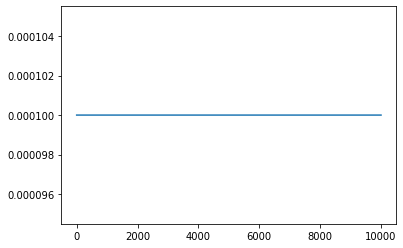

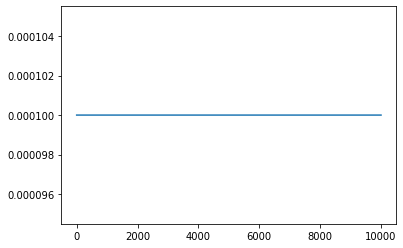

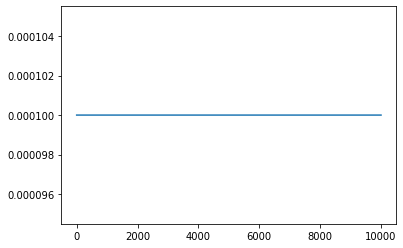

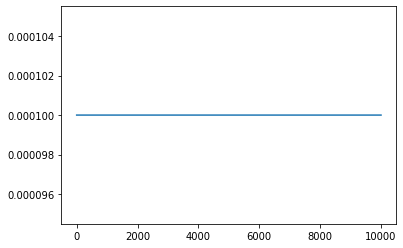

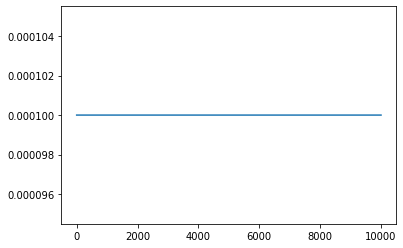

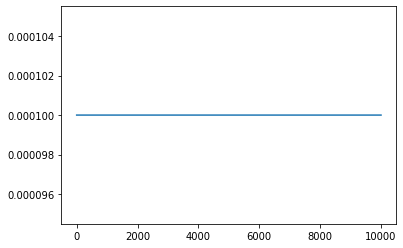

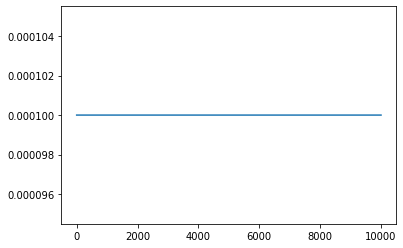

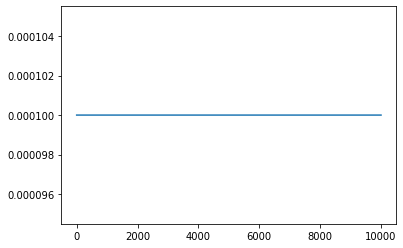

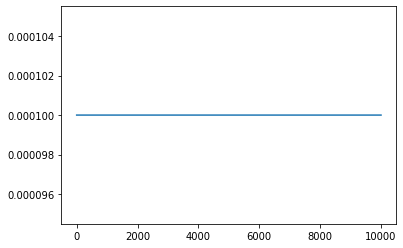

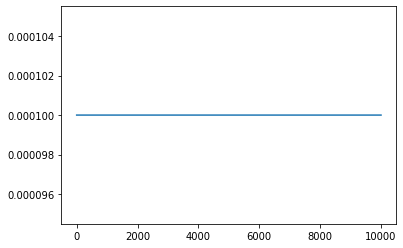

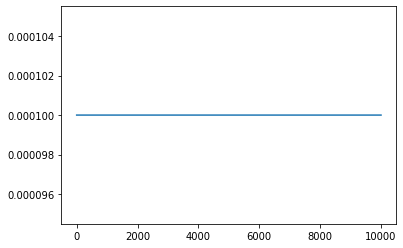

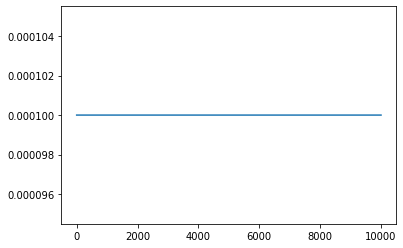

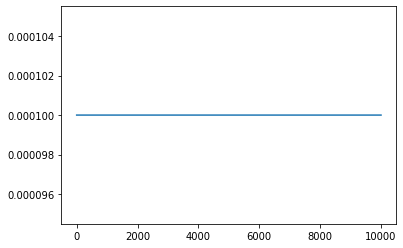

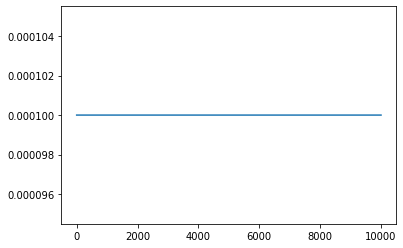

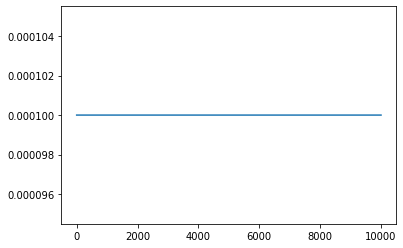

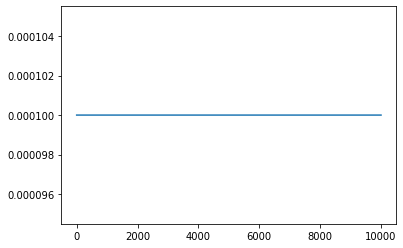

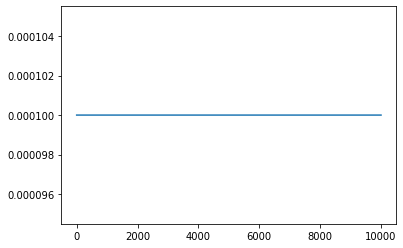

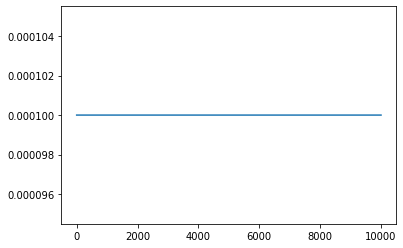

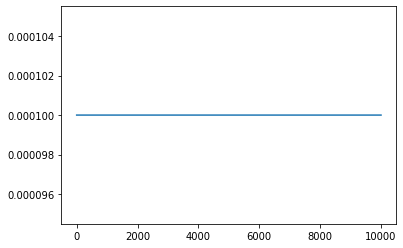

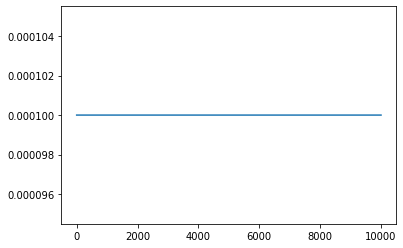

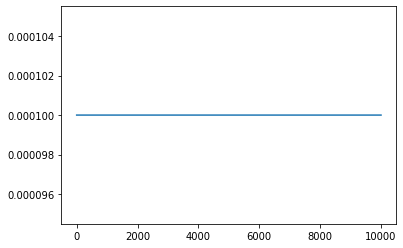

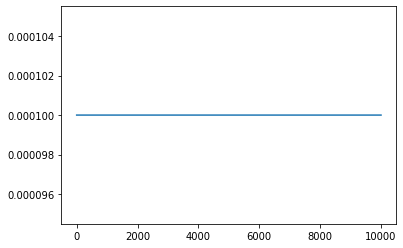

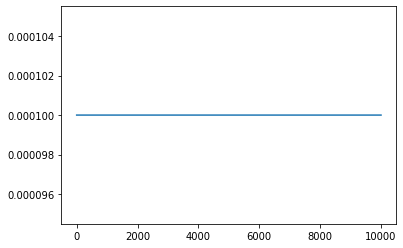

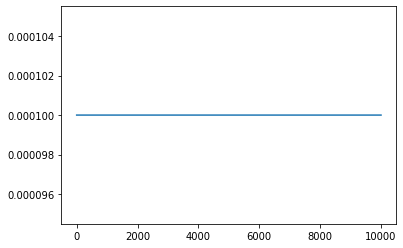

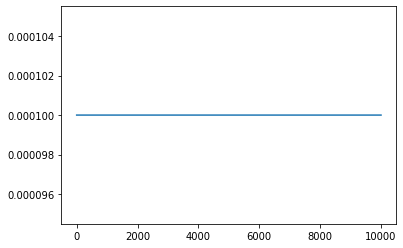

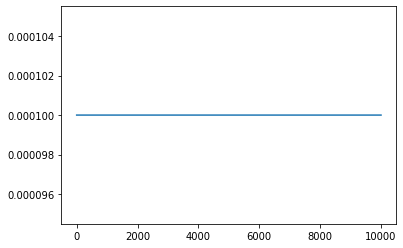

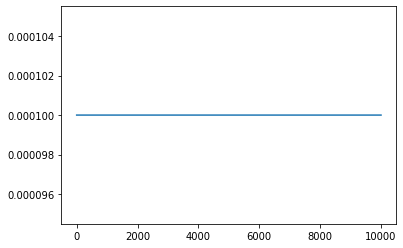

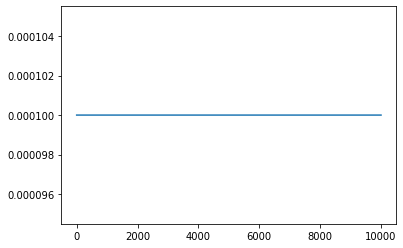

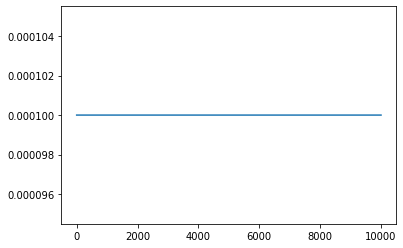

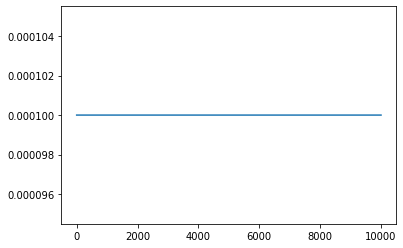

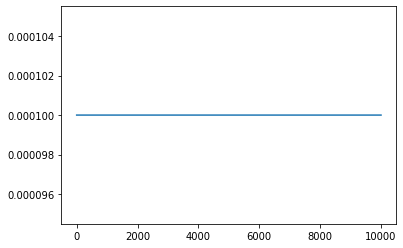

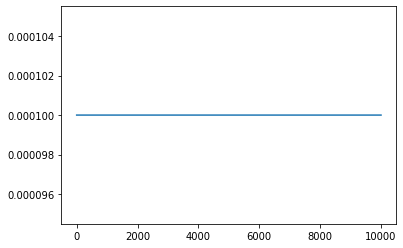

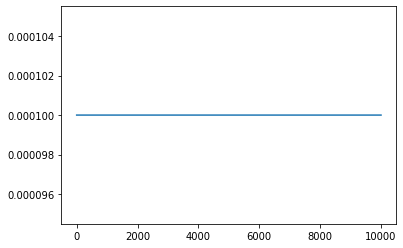

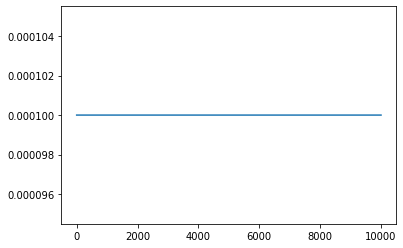

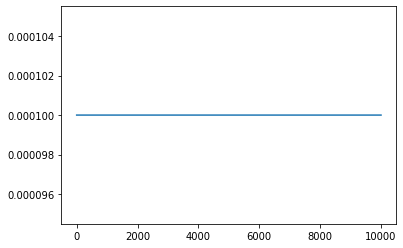

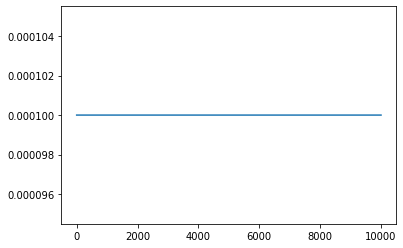

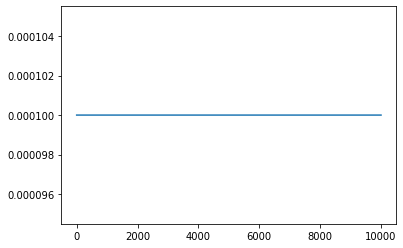

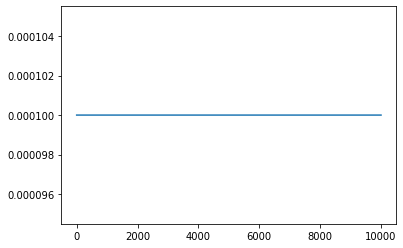

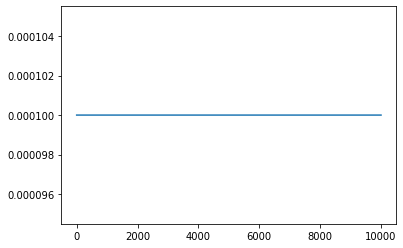

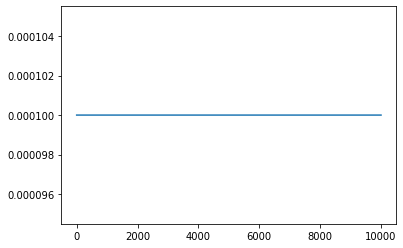

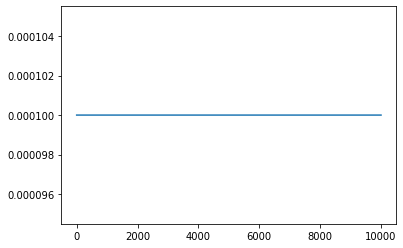

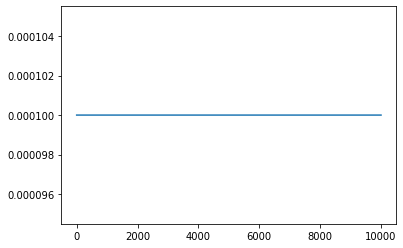

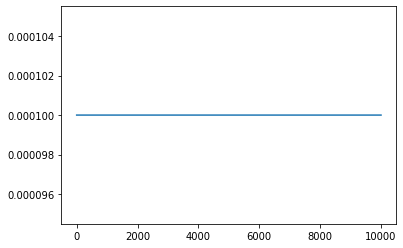

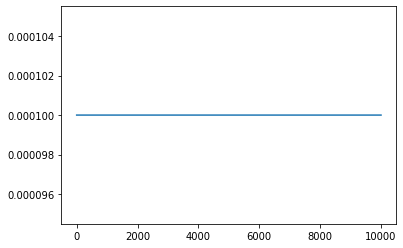

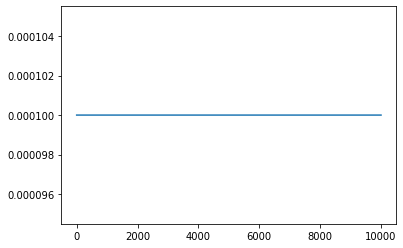

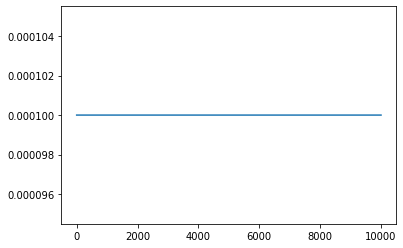

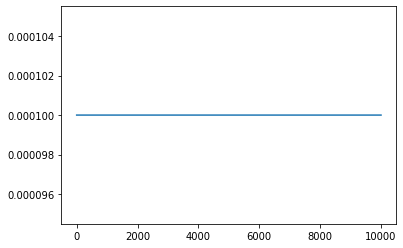

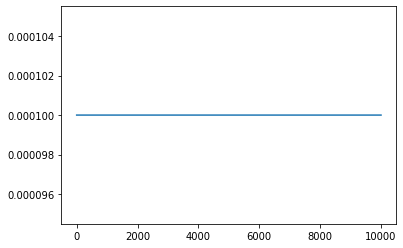

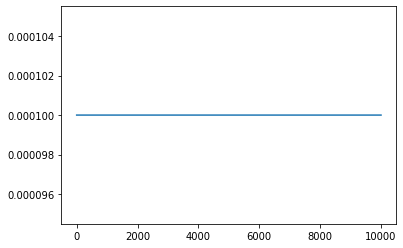

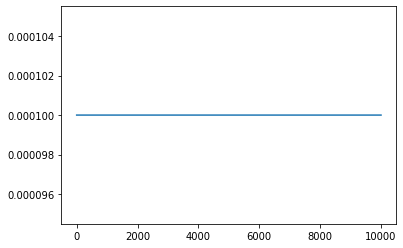

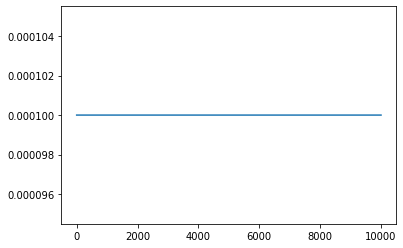

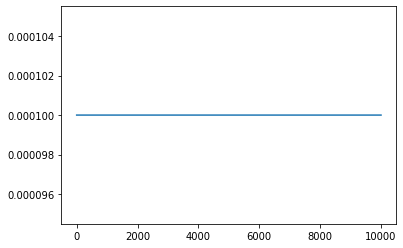

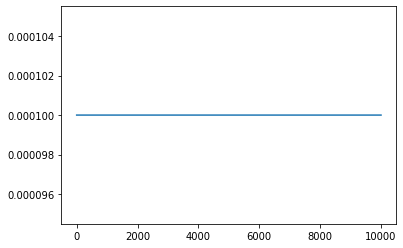

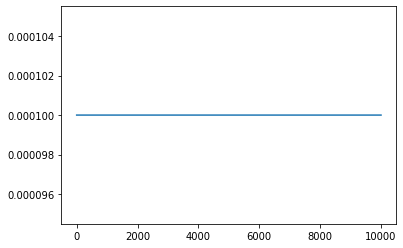

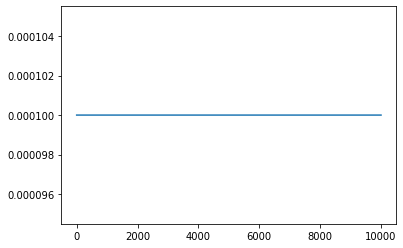

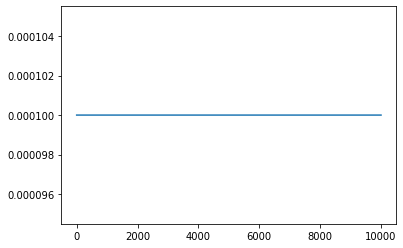

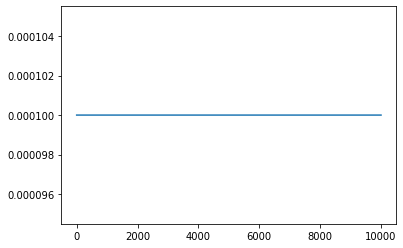

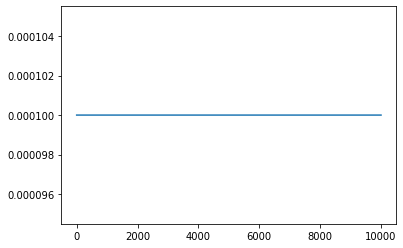

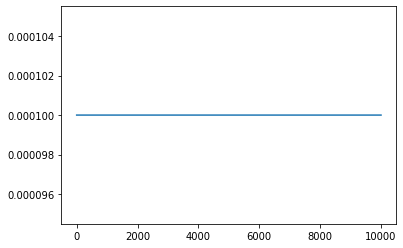

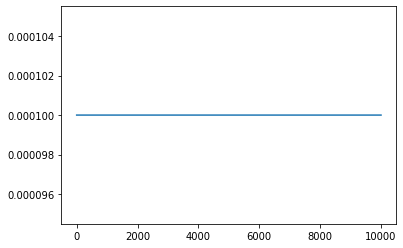

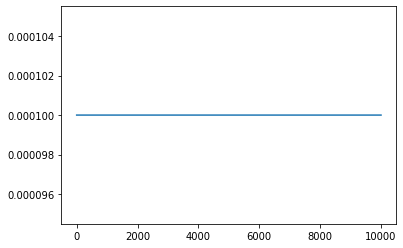

In [317]:
#plt.plot(Ws[:,0])
Ws=np.array(Ws)
print(Ws.shape)
for j in range(0,100):
    plt.plot(Ws[:,j])
    plt.show()